### Download Data

In [ ]:
# import gdown

# files = {
#     'F01.7z': "https://drive.google.com/uc?id=0B4PVUqnGmrJsMXJIekMzMm1ZTzg&export=download",
#     "F02.7z": "https://drive.google.com/uc?id=0B4PVUqnGmrJsWnFvZkp5dm5jRTQ&export=download",
#     "F04.7z": "https://drive.google.com/u/0/uc?id=0B4PVUqnGmrJsZ1N3azVMa2hFdVE&export=download",
#     "F05.7z": "https://drive.google.com/uc?id=0B4PVUqnGmrJsRnN0ZTBGYm91dk0&export=download",
#     "F06.7z": "https://drive.google.com/u/0/uc?id=0B4PVUqnGmrJsTHZhS0RubnRmRXc&export=download",
#     "F07.7z": "https://drive.google.com/uc?id=0B4PVUqnGmrJsdzBVWUwyLU1fNFE&export=download",
#     "F08.7z": "https://drive.google.com/u/0/uc?id=0B4PVUqnGmrJsQVN5ZUpvbkRjRE0&export=download",
#     "F09.7z": "https://drive.google.com/u/0/uc?id=0B4PVUqnGmrJscU5nT2otMjdpbTQ&export=download",
#     "F10.7z": "https://drive.google.com/uc?id=0B4PVUqnGmrJsM0tHdi10azVvNDQ&export=download",
#     "F11.7z": "https://drive.google.com/u/0/uc?id=0B4PVUqnGmrJsaGtldzY4aWFJOGs&export=download",
#     "M01.7z": "https://drive.google.com/uc?id=0B4PVUqnGmrJsZHhNZ09UbmE2Rm8&export=download",
#     "M02.7z": "https://drive.google.com/uc?id=0B4PVUqnGmrJsM18tOGVEV1d3b00&export=download",
#     "M04.7z": "https://drive.google.com/uc?id=0B4PVUqnGmrJsdGQyaGRkb0E2UXM&export=download",
#     "M07.7z": "https://drive.google.com/uc?id=0B4PVUqnGmrJsc204ak0yMVBTUkU&export=download",
#     "M08.7z": "https://drive.google.com/uc?id=0B4PVUqnGmrJsc2Fyb3BiMm9Rd2c&export=download"
#   }

# for key in files:
#     gdown.download(files[key], key, quiet=False)

In [ ]:
# !mkdir -p data/miracl

# for key in files:
#     file = key
#     dest = 'data/miracl/' + key.split('.')[0]
#     !7z x $key -o$dest

In [ ]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

### Import. Setup dirs, classes and speakers

In [180]:
from imutils.video import VideoStream
from imutils import face_utils
import datetime
import argparse
import imutils
import time
import dlib
import cv2
import glob
import sys
import os
import shutil 
import math
import numpy as np
from albumentations.augmentations import transforms
import skimage
from tqdm import tqdm

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from scipy import stats as s
import scipy.misc
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
img_black = np.zeros((70, 140, 3))

base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

classes = 'Begin, Choose, Connection, Navigation, Next, Previous, Start, Stop, Hello, Web'
classes = classes.split(', ')

predictor_path = 'assests/predictors/shape_predictor_68_face_landmarks.dat'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

#train_people = 'F01, F02, F04, F05, F06, F07, F08, F09, M01, M02, M04'.split(', ')
train_people = 'F01, F02, F04, F05, F06, F07, F08, F09, M01, M02, M04, F11, M08'.split(', ')
val_people = 'F10, M07'.split(', ')
#test_people = 'F11, M08'.split(', ')
print(train_people)
print(val_people)
#print(test_people)

classes_num = ['0'+str(i) if i < 10 else str(i) for i in range(1, 11) ]
word_ids = ['0'+str(i) if i < 10 else str(i) for i in range(1, 11) ]
classes_dict = dict(zip(classes_num, classes))
print(classes_num)
print(word_ids)
print(classes_dict)

In [ ]:
!rm -rf data/train
!rm -rf data/validation
!rm -rf data/test

In [ ]:
for class_name in classes:
    train_vids_dir = os.path.join(train_dir, class_name)
    val_vids_dir = os.path.join(val_dir, class_name)
    test_vids_dir = os.path.join(test_dir, class_name)
    
    os.makedirs(train_vids_dir)
    os.makedirs(val_vids_dir)
    os.makedirs(test_vids_dir)

### Extract frames, crop around mouth (train and val)

In [ ]:
counter = 0
for classi in tqdm(classes_num[:]):
    for person in train_people[:]:
        for word_id in word_ids[:]:
            for f in sorted(glob.glob(os.path.join('data/miracl/'+person+'/words/'+classi+'/'+ word_id, "*.jpg"))):
                img = cv2.imread(f, 1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                rects = detector(gray)
                
                for k, rect in enumerate(rects):
                    shape = predictor(gray, rect)
                    
                    x_51 = shape.part(51).x
                    y_51 = shape.part(51).y
                    x_57 = shape.part(57).x
                    y_57 = shape.part(57).y

                    x1_m = x_51 - 18
                    y1_m = y_51 - 7
                    x2_m = x_57 + 18
                    y2_m = y_57 + 9

                    offset_x_m = (70-(abs(x1_m-x2_m)))/2
                    offset_y_m = (35-(abs(y1_m-y2_m)))/2

                    img = img[int(y1_m-offset_y_m):int(y2_m+offset_y_m), int(x1_m-offset_x_m):int(x2_m+offset_x_m)]
                    
                    scale_percent = 200
                    width = int(img.shape[1] * scale_percent / 100)
                    height = int(img.shape[0] * scale_percent / 100)
                    dim = (width, height)
                    img = cv2.resize(img, (int(img.shape[1]*200/100), int(img.shape[0]*200/100)), interpolation=cv2.INTER_AREA) 
                    
                counter += 1
                
                cv2.imwrite('data/train/' + classes_dict[classi] + '/' + classi  + '_' + person  + '_' + word_id + '_' + f[28:-4] + '.jpg', img)

In [ ]:
counter = 0
for classi in tqdm(classes_num[:]):
    for person in val_people[:]:
        for word_id in word_ids[:]:
            for f in sorted(glob.glob(os.path.join('data/miracl/'+person+'/words/'+classi+'/'+ word_id, "*.jpg"))):
                img = cv2.imread(f, 1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                rects = detector(gray)
                
                for k, rect in enumerate(rects):
                    shape = predictor(gray, rect)
                    
                    x_51 = shape.part(51).x
                    y_51 = shape.part(51).y
                    x_57 = shape.part(57).x
                    y_57 = shape.part(57).y

                    x1_m = x_51 - 18
                    y1_m = y_51 - 7
                    x2_m = x_57 + 18
                    y2_m = y_57 + 9

                    offset_x_m = (70-(abs(x1_m-x2_m)))/2
                    offset_y_m = (35-(abs(y1_m-y2_m)))/2

                    img = img[int(y1_m-offset_y_m):int(y2_m+offset_y_m), int(x1_m-offset_x_m):int(x2_m+offset_x_m)]
                    
                    scale_percent = 200
                    width = int(img.shape[1] * scale_percent / 100)
                    height = int(img.shape[0] * scale_percent / 100)
                    dim = (width, height)
                    img = cv2.resize(img, (int(img.shape[1]*200/100), int(img.shape[0]*200/100)), interpolation=cv2.INTER_AREA) 
                    
                counter += 1
                
                cv2.imwrite('data/validation/' + classes_dict[classi] + '/' + classi  + '_' + person  + '_' + word_id + '_' + f[28:-4] + '.jpg', img)

## Get distribution of numbers of frames across videos

**Train**

In [ ]:
all_images = [] # ['data/train/Begin/01_F01_01_color_001.jpg', 'data/train/Begin/01_F01_01_color_002.jpg', 'data/train/Begin/01_F01_01_color_003.jpg' ... ]             12109
video_names = [] # ['01_F01_01', '01_F01_01', '01_F01_01' ... ]             12109
frame_nums = [] # ['001', '002', '003' ... ]            12109
video_names_uniq = [] # ['01_F01_01', '01_F01_02', '01_F01_03' ... ]            1100
frame_nums_uniq = [] # ['010', '007', '010' ... ]           1100
vids_and_frames = {} # {'01_F01_01': '010', '01_F01_02': '007', '01_F01_03': '010' ... }            1100
frames_distribution = {} # {'005': 3, '006': 20, '007': 69 ... '022': 1}            18

In [ ]:
for classi in classes_dict.values():
    for i in sorted(glob.glob('data/train/' + classi + '/*.jpg')):
        all_images.append(i)
        
for img in all_images:
    img_name = img.split('/')[-1].split('.')[0]
    video_name = img_name[:9]
    video_names.append(video_name)
    frame_num = img_name[-3:]
    frame_nums.append(frame_num)
    
video_names_uniq = list(sorted(set(video_names)))

for i in range(len(video_names)):
    if i < len(video_names)-1:
        if video_names[i] == video_names[i+1]:
            pass
        else:
            frame_nums_uniq.append(frame_nums[i])
    else:
        frame_nums_uniq.append(frame_nums[-1])
        
for i in range(len(video_names_uniq)):
    vids_and_frames[video_names_uniq[i]] = frame_nums_uniq[i]
    
for frame_num_uniq in sorted(set(frame_nums_uniq)):
    count_d = 0
    for vid_name, frames_num in list(vids_and_frames.items()):
        if frames_num == frame_num_uniq:
            count_d += 1
            frames_distribution[frame_num_uniq] = count_d

**Val**

In [ ]:
all_images_val = [] # 1746
video_names_val = [] # 1746
frame_nums_val = [] # 1746
video_names_uniq_val = [] # 200
frame_nums_uniq_val = [] # 200
vids_and_frames_val = {} # 200
frames_distribution_val = {} # 9

In [ ]:
for classi in classes_dict.values():
    for i in sorted(glob.glob('data/validation/' + classi + '/*.jpg')):
        all_images_val.append(i)
        
for img in all_images_val:
    img_name = img.split('/')[-1].split('.')[0]
    video_name = img_name[:9]
    video_names_val.append(video_name)
    frame_num = img_name[-3:]
    frame_nums_val.append(frame_num)
    
video_names_uniq_val = list(sorted(set(video_names_val)))

for i in range(len(video_names_val)):
    if i < len(video_names_val)-1:
        if video_names_val[i] == video_names_val[i+1]:
            pass
        else:
            frame_nums_uniq_val.append(frame_nums_val[i])
    else:
        frame_nums_uniq_val.append(frame_nums_val[-1])
        
for i in range(len(frame_nums_uniq_val)):
        vids_and_frames_val[video_names_uniq_val[i]] = frame_nums_uniq_val[i]
        
for frame_num_uniq_val in sorted(set(frame_nums_uniq_val)):
    count_d = 0
    for vid_name_val, frames_num_val in list(vids_and_frames_val.items()):
        if frames_num_val == frame_num_uniq_val:
            count_d += 1
            frames_distribution_val[frame_num_uniq_val] = count_d

**Plot distribution**

In [ ]:
print('Train max frames:', int(max(vids_and_frames.values())))
print('Train min frames:', int(min(vids_and_frames.values())))
print('Train mean frames:', (np.array(list(vids_and_frames.values())).astype(np.float).mean()), end = '\n\n')

print('Val max frames:', int(max(vids_and_frames_val.values())))
print('Val min frames:', int(min(vids_and_frames_val.values())))
print('Val mean frames:', (np.array(list(vids_and_frames_val.values())).astype(np.float).mean()))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,8))

ax1.bar(list(frames_distribution.keys()), [int(f) for f in frames_distribution.values()], 0.7)
ax1.grid(axis = 'y')
ax1.set_yticks(np.arange(0, max(frames_distribution.values())+2, 10))

ax2.bar(list(frames_distribution_val.keys()), [int(f) for f in frames_distribution_val.values()], 0.7)
ax2.grid(axis = 'y')
ax2.set_yticks(np.arange(0, max(frames_distribution_val.values())+2, 10)) 

fig.show()

**Stats across classes**

In [ ]:
video_names_in_class_dict = {}
idx = 0

for classi in classes_dict.values():
    video_names_in_class_dict[classi] = {}
    video_names_in_class_dict[classi]['num of frames'] = 0
    video_names_in_class_dict[classi]['num of vids'] = 0
    video_names_in_class_dict[classi]['vids'] = []
    video_names_in_class_dict[classi]['frames per vid'] = []
    video_names_in_class_dict[classi]['mean frames per vid'] = 0

    all_images_in_class = []
    video_names = []
    video_names_uniq_in_class = []
    frame_nums_in_class = []
    frame_nums_uniq_in_class = []
    vids_and_frames_in_class = {}

    counter = 0

    for i in sorted(glob.glob('data/train/' + classi + '/*.jpg')):
        all_images_in_class.append(i)
        counter += 1

    video_names_in_class_dict[classi]['num of frames'] = counter

    for img in all_images_in_class:
        img_name = img.split('/')[-1].split('.')[0]
        video_name = img_name[:9]
        video_names.append(video_name)
        frame_num = img_name[-3:]
        frame_nums_in_class.append(frame_num)

    video_names_uniq_in_class = list(sorted(set(video_names)))

    video_names_in_class_dict[classi]['vids'] = video_names_uniq_in_class
    video_names_in_class_dict[classi]['num of vids'] = len(video_names_uniq_in_class)

    for i in range(len(video_names)):
        if i < len(video_names)-1:
            if video_names[i] == video_names[i+1]:
                pass
            else:
                frame_nums_uniq_in_class.append(frame_nums_in_class[i])
        else:
            frame_nums_uniq_in_class.append(frame_nums_in_class[-1])

    for i in range(len(video_names_uniq_in_class)):
        vids_and_frames_in_class[video_names_uniq_in_class[i]] = frame_nums_uniq_in_class[i]

    video_names_in_class_dict[classi]['frames per vid'] = list(vids_and_frames_in_class.values())
    video_names_in_class_dict[classi]['mean frames per vid'] = np.array(list(list(video_names_in_class_dict.values())[idx].values())[3]).astype(np.float).mean()

    idx += 1

In [ ]:
[list(list(video_names_in_class_dict.values())[f].values())[1] for f in range(len(classes))]

In [ ]:
# График слева - сколько всего фреймов в видосах у каждого класса + количество видосов. Изначально их по 130 у каждого класса
# График справа - среднее число кадров в видео у каждого класса

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,8))

ax1.bar(list(video_names_in_class_dict.keys()), [list(list(video_names_in_class_dict.values())[f].values())[0] for f in range(len(classes))], 0.7)
ax1.grid(axis = 'y')
ax1.set_yticks(np.arange(0, max([list(list(video_names_in_class_dict.values())[f].values())[0] for f in range(len(classes))]) + 2, 150))

ax1.bar(list(video_names_in_class_dict.keys()), [list(list(video_names_in_class_dict.values())[f].values())[1] for f in range(len(classes))], 0.7)
ax1.grid(axis = 'y')
#ax2.set_yticks(np.arange(0, max([list(list(video_names_in_class_dict.values())[f].values())[1] for f in range(len(classes))]) + 2, 150))

ax2.bar(list(video_names_in_class_dict.keys()), [list(list(video_names_in_class_dict.values())[f].values())[4] for f in range(len(classes))], 0.7)
ax2.grid(axis = 'y')
ax2.set_yticks(np.arange(0, max([list(list(video_names_in_class_dict.values())[f].values())[4] for f in range(len(classes))]) + 2, 1))

fig.show()

In [ ]:
# import json
# import google

# with open('video_names_in_class.json', 'w') as jfile:
#     json.dump(video_names_in_class, jfile)

# google.colab.files.download('video_names_in_class.json')

## Delete videos either too short or too long

**Train**

In [ ]:
comp = {}
for frame_num_uniq in sorted(set(frame_nums_uniq)):
    comp[frame_num_uniq] = {}
    comp[frame_num_uniq]['class'] = []
    comp[frame_num_uniq]['person'] = []
    comp[frame_num_uniq]['video_names'] = []
    comp[frame_num_uniq]['videos_count'] = 0
    for vid_name, frames_num in list(vids_and_frames.items()):
        if frames_num == frame_num_uniq:
            if vid_name.split('_')[0] not in comp[frame_num_uniq]['class']:
                comp[frame_num_uniq]['class'].append(vid_name.split('_')[0])
            if vid_name.split('_')[1] not in comp[frame_num_uniq]['person']:
                comp[frame_num_uniq]['person'].append(vid_name.split('_')[1])
            if vid_name not in comp[frame_num_uniq]['video_names']:
                comp[frame_num_uniq]['video_names'].append(vid_name)
                comp[frame_num_uniq]['videos_count'] += 1

# get the most common number of frames
maxer = 0
maxer_key = 0
for key in frames_distribution:
    if frames_distribution[key] >= maxer:
        maxer = frames_distribution[key]
        maxer_key = key

# videos either too short or too long (with num. of frames not in [7, 8, 9, 10, 11, 12, 13])
# total to 233 vids
abnormal_vids = []
for key in comp:
    for video_name in comp[key]['video_names']:
        if int(key) not in range(int(maxer_key)-3, int(maxer_key)+1):
            abnormal_vids.append(video_name)
abnormal_vids = sorted(abnormal_vids)

In [ ]:
list(range(int(maxer_key)-3, int(maxer_key)+1))

In [ ]:
# remove not needed
# debug note: the last print must return "Removed 233 videos" - the number of videos to remove

counter = 0
added = 0
matched = []
for classi in list(classes_dict.values()):
    removed = 0
    for abnormal_vid in abnormal_vids:
        for vid in sorted(glob.glob('data/train/' + classi + '/*.jpg')):
            if abnormal_vid == vid.split('/')[-1].split('.')[0].split('_color')[0]:
                os.remove(vid)
                #!rm $vid
                matched.append(abnormal_vid)
                counter += 1
                removed += 1
    print(classi, 'Removed', counter, '(' , removed, 'in this dir)')

print()
print('Removed', len(set(matched)), 'videos')

In [ ]:
# optionally, save the distribution as a json and visualize
# https://codebeautify.org/jsonviewer

# import json
# from google.colab import files

# with open('comp.json', 'w') as jfile:
#     json.dump(comp, jfile)

# files.download('comp.json')

In [ ]:
comp_val = {}
for frame_num_uniq_val in sorted(set(frame_nums_uniq_val)):
    comp_val[frame_num_uniq_val] = {}
    comp_val[frame_num_uniq_val]['class'] = []
    comp_val[frame_num_uniq_val]['person'] = []
    comp_val[frame_num_uniq_val]['video_names'] = []
    comp_val[frame_num_uniq_val]['videos_count'] = 0
    for vid_name_val, frames_num_val in list(vids_and_frames_val.items()):
        if frames_num_val == frame_num_uniq_val:
            if vid_name_val.split('_')[0] not in comp_val[frame_num_uniq_val]['class']:
                comp_val[frame_num_uniq_val]['class'].append(vid_name_val.split('_')[0])
            if vid_name_val.split('_')[1] not in comp_val[frame_num_uniq_val]['person']:
                comp_val[frame_num_uniq_val]['person'].append(vid_name_val.split('_')[1])
            if vid_name_val not in comp_val[frame_num_uniq_val]['video_names']:
                comp_val[frame_num_uniq_val]['video_names'].append(vid_name_val)
                comp_val[frame_num_uniq_val]['videos_count'] += 1

maxer = 0
maxer_key = 0
for key in frames_distribution_val:
    if frames_distribution_val[key] >= maxer:
        maxer = frames_distribution_val[key]
        maxer_key = key

# videos either too short or too long (with num. of frames not in [6, 7, 8, 9, 10])
# total to 35 vids
abnormal_vids = []
for key in comp_val:
    for video_name in comp_val[key]['video_names']:
        if int(key) not in range(int(maxer_key)-1, int(maxer_key)+3):
            abnormal_vids.append(video_name)
abnormal_vids = sorted(abnormal_vids)

In [ ]:
list(range(int(maxer_key)-1, int(maxer_key)+3))

In [ ]:
# debug note: the past print must return "Removed 35 videos" - the number of videos to remove
counter = 0
added = 0
matched = []
for classi in list(classes_dict.values()):
    removed = 0
    for abnormal_vid in abnormal_vids:
        for vid in sorted(glob.glob('data/validation/' + classi + '/*.jpg')):
            if abnormal_vid == vid.split('/')[-1].split('.')[0].split('_color')[0]:
                os.remove(vid)
                matched.append(abnormal_vid)
                counter += 1
                removed += 1
    print(classi, 'Removed', counter, '(' , removed, 'in this dir)')

print()
print('Removed', len(set(matched)), 'videos')

In [ ]:
# optionally, save the distribution as a json and visualize
# https://codebeautify.org/jsonviewer

# import json
# from google.colab import files

# with open('comp_val.json', 'w') as jfile:
#     json.dump(comp_val, jfile)

# files.download('comp_val.json')

## Check the distribution again

**Train**

In [ ]:
all_images = [] # 8699 vs 12109
video_names = [] # 8699 vs 12109
frame_nums = [] # 8699 vs 12109
video_names_uniq = [] # 867 vs 1100
frame_nums_uniq = [] # 867 vs 1100
vids_and_frames = {} # 867 vs 1100
frames_distribution = {} # 7 vs 18

In [ ]:
for classi in classes_dict.values():
    for i in sorted(glob.glob('data/train/' + classi + '/*.jpg')):
        all_images.append(i)
        
for img in all_images:
    img_name = img.split('/')[-1].split('.')[0]
    video_name = img_name[:9]
    video_names.append(video_name)
    frame_num = img_name[-3:]
    frame_nums.append(frame_num)
    
video_names_uniq = list(sorted(set(video_names)))

for i in range(len(video_names)):
    if i < len(video_names)-1:
        if video_names[i] == video_names[i+1]:
            pass
        else:
            frame_nums_uniq.append(frame_nums[i])
    else:
        frame_nums_uniq.append(frame_nums[-1])
        
for i in range(len(video_names_uniq)):
    vids_and_frames[video_names_uniq[i]] = frame_nums_uniq[i]
    
for frame_num_uniq in sorted(set(frame_nums_uniq)):
    count_d = 0
    for vid_name, frames_num in list(vids_and_frames.items()):
        if frames_num == frame_num_uniq:
            count_d += 1
            frames_distribution[frame_num_uniq] = count_d

**Val**

In [ ]:
all_images_val = [] # 1364 vs 1746
video_names_val = [] # 1364 vs 1746
frame_nums_val = [] # 1364 vs 1746
video_names_uniq_val = [] # 165 vs 200
frame_nums_uniq_val = [] # 165 vs 200
vids_and_frames_val = {} # 165 vs 200
frames_distribution_val = {} # 5 vs 9

In [ ]:
for classi in classes_dict.values():
    for i in sorted(glob.glob('data/validation/' + classi + '/*.jpg')):
        all_images_val.append(i)
        
for img in all_images_val:
    img_name = img.split('/')[-1].split('.')[0]
    video_name = img_name[:9]
    video_names_val.append(video_name)
    frame_num = img_name[-3:]
    frame_nums_val.append(frame_num)
    
video_names_uniq_val = list(sorted(set(video_names_val)))

for i in range(len(video_names_val)):
    if i < len(video_names_val)-1:
        if video_names_val[i] == video_names_val[i+1]:
            pass
        else:
            frame_nums_uniq_val.append(frame_nums_val[i])
    else:
        frame_nums_uniq_val.append(frame_nums_val[-1])
        
for i in range(len(frame_nums_uniq_val)):
        vids_and_frames_val[video_names_uniq_val[i]] = frame_nums_uniq_val[i]
        
for frame_num_uniq_val in sorted(set(frame_nums_uniq_val)):
    count_d = 0
    for vid_name_val, frames_num_val in list(vids_and_frames_val.items()):
        if frames_num_val == frame_num_uniq_val:
            count_d += 1
            frames_distribution_val[frame_num_uniq_val] = count_d

**Plot distribution**

In [ ]:
print('Train max frames:', int(max(vids_and_frames.values())))
print('Train min frames:', int(min(vids_and_frames.values())))
print('Train mean frames:', (np.array(list(vids_and_frames.values())).astype(np.float).mean()), end = '\n\n')

print('Val max frames:', int(max(vids_and_frames_val.values())))
print('Val min frames:', int(min(vids_and_frames_val.values())))
print('Val mean frames:', (np.array(list(vids_and_frames_val.values())).astype(np.float).mean()))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,8))

ax1.bar(list(frames_distribution.keys()), [int(f) for f in frames_distribution.values()], 0.7)
ax1.grid(axis = 'y')
ax1.set_yticks(np.arange(0, max(frames_distribution.values())+2, 10))

ax2.bar(list(frames_distribution_val.keys()), [int(f) for f in frames_distribution_val.values()], 0.7)
ax2.grid(axis = 'y')
ax2.set_yticks(np.arange(0, max(frames_distribution_val.values())+2, 10)) 

fig.show()

**Stats across classes**

In [ ]:
video_names_in_class_dict = {}
idx = 0

for classi in classes_dict.values():
    video_names_in_class_dict[classi] = {}
    video_names_in_class_dict[classi]['num of frames'] = 0
    video_names_in_class_dict[classi]['num of vids'] = 0
    video_names_in_class_dict[classi]['vids'] = []
    video_names_in_class_dict[classi]['frames per vid'] = []
    video_names_in_class_dict[classi]['mean frames per vid'] = 0

    all_images_in_class = []
    video_names = []
    video_names_uniq_in_class = []
    frame_nums_in_class = []
    frame_nums_uniq_in_class = []
    vids_and_frames_in_class = {}

    counter = 0

    for i in sorted(glob.glob('data/train/' + classi + '/*.jpg')):
        all_images_in_class.append(i)
        counter += 1

    video_names_in_class_dict[classi]['num of frames'] = counter

    for img in all_images_in_class:
        img_name = img.split('/')[-1].split('.')[0]
        video_name = img_name[:9]
        video_names.append(video_name)
        frame_num = img_name[-3:]
        frame_nums_in_class.append(frame_num)

    video_names_uniq_in_class = list(sorted(set(video_names)))

    video_names_in_class_dict[classi]['vids'] = video_names_uniq_in_class
    video_names_in_class_dict[classi]['num of vids'] = len(video_names_uniq_in_class)

    for i in range(len(video_names)):
        if i < len(video_names)-1:
            if video_names[i] == video_names[i+1]:
                pass
            else:
                frame_nums_uniq_in_class.append(frame_nums_in_class[i])
        else:
            frame_nums_uniq_in_class.append(frame_nums_in_class[-1])

    for i in range(len(video_names_uniq_in_class)):
        vids_and_frames_in_class[video_names_uniq_in_class[i]] = frame_nums_uniq_in_class[i]

    video_names_in_class_dict[classi]['frames per vid'] = list(vids_and_frames_in_class.values())
    video_names_in_class_dict[classi]['mean frames per vid'] = np.array(list(list(video_names_in_class_dict.values())[idx].values())[3]).astype(np.float).mean()

    idx += 1

In [ ]:
[list(list(video_names_in_class_dict.values())[f].values())[1] for f in range(len(classes))]

In [ ]:
# Видим просадку у класса Navigation - было 130 видео, стало 80. Число кадров соотевтстенно тоже упало.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,8))

ax1.bar(list(video_names_in_class_dict.keys()), [list(list(video_names_in_class_dict.values())[f].values())[0] for f in range(len(classes))], 0.7)
ax1.grid(axis = 'y')
ax1.set_yticks(np.arange(0, max([list(list(video_names_in_class_dict.values())[f].values())[0] for f in range(len(classes))]) + 2, 150))

ax1.bar(list(video_names_in_class_dict.keys()), [list(list(video_names_in_class_dict.values())[f].values())[1] for f in range(len(classes))], 0.7)
ax1.grid(axis = 'y')
#ax2.set_yticks(np.arange(0, max([list(list(video_names_in_class_dict.values())[f].values())[1] for f in range(len(classes))]) + 2, 150))

ax2.bar(list(video_names_in_class_dict.keys()), [list(list(video_names_in_class_dict.values())[f].values())[4] for f in range(len(classes))], 0.7)
ax2.grid(axis = 'y')
ax2.set_yticks(np.arange(0, max([list(list(video_names_in_class_dict.values())[f].values())[4] for f in range(len(classes))]) + 2, 1))

fig.show()

## Perform padding

In [ ]:
# make sure that padding's shape equals to (w x h x c) of the train images

print(img_black.shape)

In [ ]:
target_frame_num = int(max(vids_and_frames.values())) #13
target_frame_num_val = int(max(vids_and_frames_val.values())) # 10
print(target_frame_num)
print(target_frame_num_val)

In [ ]:
# pad train

for classi in classes_dict.keys():
    for vid in vids_and_frames.keys():
        if classi == vid.split('_')[0]:
            if int(vids_and_frames[vid]) < target_frame_num:
                for i in range(1, (target_frame_num - int(vids_and_frames[vid]) + 1)):
                    cv2.imwrite('data/train/' + classes_dict[classi] + '/' + vid + '_' + 'color' + '_' + str(int(vids_and_frames[vid]) + i).zfill(3) + '.jpg', img_black)

In [ ]:
# pad val
# has to be padded to 13 ... not 10

for classi in classes_dict.keys():
    for vid in vids_and_frames_val.keys():
        if classi == vid.split('_')[0]:
            if int(vids_and_frames_val[vid]) < target_frame_num:
                for i in range(1, (target_frame_num - int(vids_and_frames_val[vid]) + 1)):
                    cv2.imwrite('data/validation/' + classes_dict[classi] + '/' + vid + '_' + 'color' + '_' + str(int(vids_and_frames_val[vid]) + i).zfill(3) + '.jpg', img_black)

## Check the distribution the last time to be sure

**Train**

In [ ]:
all_images = [] # 11271 vs 8699 vs 12109
video_names = [] # 11271 vs 8699 vs 12109
frame_nums = [] # 11271 vs 8699 vs 12109
video_names_uniq = [] # 867 vs 867 vs 1100
frame_nums_uniq = [] # 867 vs 867 vs 1100
vids_and_frames = {} # 867 vs 867 vs 1100
frames_distribution = {} # 1 vs 7 vs 18

In [ ]:
for classi in classes_dict.values():
    for i in sorted(glob.glob('data/train/' + classi + '/*.jpg')):
        all_images.append(i)
        
for img in all_images:
    img_name = img.split('/')[-1].split('.')[0]
    video_name = img_name[:9]
    video_names.append(video_name)
    frame_num = img_name[-3:]
    frame_nums.append(frame_num)
    
video_names_uniq = list(sorted(set(video_names)))

for i in range(len(video_names)):
    if i < len(video_names)-1:
        if video_names[i] == video_names[i+1]:
            pass
        else:
            frame_nums_uniq.append(frame_nums[i])
    else:
        frame_nums_uniq.append(frame_nums[-1])
        
for i in range(len(video_names_uniq)):
    vids_and_frames[video_names_uniq[i]] = frame_nums_uniq[i]
    
for frame_num_uniq in sorted(set(frame_nums_uniq)):
    count_d = 0
    for vid_name, frames_num in list(vids_and_frames.items()):
        if frames_num == frame_num_uniq:
            count_d += 1
            frames_distribution[frame_num_uniq] = count_d

**Val**

In [ ]:
all_images_val = [] # 1650 vs 1364 vs 1746
video_names_val = [] # 1650 vs 1364 vs 1746
frame_nums_val = [] # 1650 vs 1364 vs 1746
video_names_uniq_val = [] # 165 vs 165 vs 200
frame_nums_uniq_val = [] # 165 vs 165 vs 200
vids_and_frames_val = {} # 165 vs 165 vs 200
frames_distribution_val = {} # 1 vs 5 vs 9

In [ ]:
for classi in classes_dict.values():
    for i in sorted(glob.glob('data/validation/' + classi + '/*.jpg')):
        all_images_val.append(i)
        
for img in all_images_val:
    img_name = img.split('/')[-1].split('.')[0]
    video_name = img_name[:9]
    video_names_val.append(video_name)
    frame_num = img_name[-3:]
    frame_nums_val.append(frame_num)
    
video_names_uniq_val = list(sorted(set(video_names_val)))

for i in range(len(video_names_val)):
    if i < len(video_names_val)-1:
        if video_names_val[i] == video_names_val[i+1]:
            pass
        else:
            frame_nums_uniq_val.append(frame_nums_val[i])
    else:
        frame_nums_uniq_val.append(frame_nums_val[-1])
        
for i in range(len(frame_nums_uniq_val)):
        vids_and_frames_val[video_names_uniq_val[i]] = frame_nums_uniq_val[i]
        
for frame_num_uniq_val in sorted(set(frame_nums_uniq_val)):
    count_d = 0
    for vid_name_val, frames_num_val in list(vids_and_frames_val.items()):
        if frames_num_val == frame_num_uniq_val:
            count_d += 1
            frames_distribution_val[frame_num_uniq_val] = count_d

In [ ]:
# Now all the videos are of 13 frames

print('Train max frames:', int(max(vids_and_frames.values())))
print('Train min frames:', int(min(vids_and_frames.values())))
print('Train mean frames:', (np.array(list(vids_and_frames.values())).astype(np.float).mean()), end = '\n\n')

print('Val max frames:', int(max(vids_and_frames_val.values())))
print('Val min frames:', int(min(vids_and_frames_val.values())))
print('Val mean frames:', (np.array(list(vids_and_frames_val.values())).astype(np.float).mean()))

## Perform augmentations

In [ ]:
# Вспомогательная функция для удобного переименования видео.

# def get_idx(classi):
#     start_idx = (len('data/train/') + len(classi)+1)
#     return start_idx

In [ ]:
# # Оставил только горизонтальный поворот и шум.

# for classi in classes:
#     files = [file for file in sorted(glob.glob(os.path.join('data/train/' + classi + '/*.jpg')))]
#     files_clean = [file_clean for file_clean in sorted(files)
#                 if 'vert_flip' not in file_clean
#                 and 'hor_flip' not in file_clean
#                 and 'rot_45' not in file_clean
#                 and 'rot_315' not in file_clean
#                 and 'rot_135' not in file_clean
#                 and 'rot_225' not in file_clean
#                 and 'rot_90' not in file_clean
#                 and 'rot_270' not in file_clean
#                 and 'rand_contr' not in file_clean
#                 and 'noised' not in file_clean]
#     files_rem = [file_rem for file_rem in sorted(files)
#                 if 'vert_flip' in file_rem
#                 or 'hor_flip' in file_rem
#                 or 'rot_45' in file_rem
#                 or 'rot_315' in file_rem
#                 or 'rot_135' in file_rem
#                 or 'rot_225' in file_rem
#                 or 'rot_90' in file_rem
#                 or 'rot_270' in file_rem
#                 or 'rand_contr' in file_rem
#                 or 'noised' in file_rem]
#     for file_to_rem in files_rem: os.remove(file_to_rem)
#     files = [file for file in sorted(glob.glob(os.path.join('data/train/' + classi + '/*.jpg')))]
#     print(classi, 'dir: removed', len(files_rem), 'files.', len(files), 'to be augmented')

#     for file_to_hor_flip in files_clean:
#         img = cv2.imread(file_to_hor_flip, 1)
#         img = transforms.HorizontalFlip().apply(img)
#         file_to_write = file_to_hor_flip[:get_idx(classi)] + '[hor_flip]' + file_to_hor_flip[get_idx(classi):]
#         cv2.imwrite(file_to_write, img)
#     files = [file for file in sorted(glob.glob(os.path.join('data/train/' + classi + '/*.jpg')))]
#     files_hor_flipped = [file_hor_flipped for file_hor_flipped in sorted(files) if 'hor_flip' in file_hor_flipped]
#     print('Horizontally flipped', len(files_hor_flipped), 'files.', len(files), 'in the directory')
    
#     for file_to_vert_flip in files_clean:
#         img = cv2.imread(file_to_vert_flip, 1)
#         img = transforms.VerticalFlip().apply(img)
#         file_to_write = file_to_vert_flip[:get_idx(classi)] + '[vert_flip]' + file_to_vert_flip[get_idx(classi):]
#         cv2.imwrite(file_to_write, img)
#     files = [file for file in sorted(glob.glob(os.path.join('data/train/' + classi + '/*.jpg')))]
#     files_vert_flipped = [file_vert_flipped for file_vert_flipped in sorted(files) if 'vert_flip' in file_vert_flipped]
#     print('Vertically flipped', len(files_vert_flipped), 'files.', len(files), 'in the directory')
    
#     files_not_rand_contred = [file_not_rand_contred for file_not_rand_contred in sorted(files) if 'rand_contr' not in file_not_rand_contred]
#     for file_to_noise in files_not_rand_contred:
#         if '[hor_flip]' in file_to_noise:
#             img = cv2.imread(file_to_noise, 1)
#             gauss = np.random.uniform(0, 64, img.size)
#             gauss = gauss.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
#             img = cv2.add(img,gauss)
#             file_to_write = file_to_noise[:get_idx(classi)] + '[noised]' + file_to_noise[get_idx(classi):]
#             cv2.imwrite(file_to_write, img)
#         elif '[vert_flip]' in file_to_noise:
#             img = cv2.imread(file_to_noise, 1)
#             gauss = np.random.uniform(0, 64, img.size)
#             gauss = gauss.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
#             img = cv2.add(img,gauss)
#             file_to_write = file_to_noise[:get_idx(classi)] + '[noised]' + file_to_noise[get_idx(classi):]
#             cv2.imwrite(file_to_write, img)
#         else:
#             img = cv2.imread(file_to_noise, 1)
#             gauss = np.random.uniform(0, 64, img.size)
#             gauss = gauss.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
#             img = cv2.add(img,gauss)
#             file_to_write = file_to_noise[:get_idx(classi)] + '[noised]' + file_to_noise[get_idx(classi):]
#             cv2.imwrite(file_to_write, img)
#     files = [file for file in sorted(glob.glob(os.path.join('data/train/' + classi + '/*.jpg')))]
#     files_noised = [file_noised for file_noised in sorted(files) if 'noised' in file_noised]
#     print('Noised', len(files_noised), 'files.', len(files), 'in the directory')

#     files_not_noised = [file_not_noised for file_not_noised in sorted(files) if 'noised' not in file_not_noised ]    
#     for file_to_rand_contr in files_not_noised:
#         if '[hor_flip]' in file_to_rand_contr:
#             img = cv2.imread(file_to_rand_contr, 1)
#             img = transforms.RandomContrast().apply(img)
#             file_to_write = file_to_rand_contr[:get_idx(classi)] + '[rand_contr]' + file_to_rand_contr[get_idx(classi):]
#             cv2.imwrite(file_to_write, img)
#         elif '[vert_flip]' in file_to_rand_contr:
#             img = cv2.imread(file_to_rand_contr, 1)
#             img = transforms.RandomContrast().apply(img)
#             file_to_write = file_to_rand_contr[:get_idx(classi)] + '[rand_contr]' + file_to_rand_contr[get_idx(classi):]
#             cv2.imwrite(file_to_write, img)
#         else:
#             img = cv2.imread(file_to_rand_contr, 1)
#             img = transforms.RandomContrast().apply(img)
#             file_to_write = file_to_rand_contr[:get_idx(classi)] + '[rand_contr]' + file_to_rand_contr[get_idx(classi):]
#             cv2.imwrite(file_to_write, img)
#     files = [file for file in sorted(glob.glob(os.path.join('data/train/' + classi + '/*.jpg')))]
#     files_rand_contred = [file_rand_contred for file_rand_contred in sorted(files) if 'rand_contr' in file_rand_contred]
#     print('Random contrasted', len(files_rand_contred), 'files.', len(files), 'in the directory')
    
    
#     print()

## Save frames to csv. Compress to zip archives

In [ ]:
train_image = []
train_class = []

for class_id in range(len(classes)):
    images = sorted(glob.glob('data/train/' + classes[class_id] + '/*.jpg'))
    for i in range(len(images)):
        if ('noised' in images[i] or 'rand_contr' in images[i]
        or 'vert_flip' in images[i] or 'hor_flip' in images[i]):
            train_image.append(images[i].split('/')[3])
            train_class.append(classes_dict[images[i].split('/')[3].split(']')[-1][:2]])
        else:
            train_image.append(images[i].split('/')[3])
            train_class.append(classes_dict[images[i].split('/')[3].split('_')[0]])
        
train_data = pd.DataFrame()
train_data['image'] = train_image
train_data['class'] = train_class

train_data.to_csv('data/miracl/train_new.csv',header=True, index=False)


val_image = []
val_class = []

for class_id in range(len(classes)):
    images = sorted(glob.glob('data/validation/' + classes[class_id] + '/*.jpg'))
    for i in range(len(images)):
        val_image.append(images[i].split('/')[3])
        val_class.append(classes_dict[images[i].split('/')[3].split('_')[0]])
val_data = pd.DataFrame()
val_data['image'] = val_image
val_data['class'] = val_class

val_data.to_csv('data/miracl/val_new.csv',header=True, index=False)

In [ ]:
train = pd.read_csv('data/miracl/train_new.csv')
val = pd.read_csv('data/miracl/val_new.csv')

y_tr = train['class']
y_tr_dummy = pd.get_dummies(y_tr)

y_val = val['class']
y_val_dummy = pd.get_dummies(y_val)

In [ ]:
train.head()

In [ ]:
train.tail()

In [ ]:
val.head()

In [ ]:
val.tail()

In [ ]:
# 101439 train images
# 1650 val images

print(len(train))
print(len(val))

In [ ]:
# # export as zip
# from google.colab import files

# !7z a -t7z train_data.zip /content/data/train -o/content
# !7z a -t7z val_data.zip /content/data/validation -o/content

In [ ]:
# files.download('val_data.zip')

In [ ]:
# files.download('train_data.zip')

## Prepare data generator

In [1]:
import tensorflow as tf

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [3]:
# tf.compat.v1.InteractiveSession.close(session)

In [4]:
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import Dense, InputLayer, Dropout, Flatten, Activation, GRU, Input, Conv3D, MaxPooling3D, GlobalMaxPooling3D, ZeroPadding3D, AveragePooling3D
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Convolution2D, ZeroPadding2D, Bidirectional, TimeDistributed, GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from keras.preprocessing import image, sequence
from keras.callbacks import ModelCheckpoint


from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.layers import *
from keras.regularizers import *

Using TensorFlow backend.


In [227]:
import math
import numpy as np
from keras.models import Model
# # !wget https://gist.githubusercontent.com/Emadeldeen-24/736c33ac2af0c00cc48810ad62e1f54a/raw/f2428c9ba7c13e08e2aa9b2d5ff64ad575a99dd8/tweaked_ImageGenerator_v2.py
from tweaked_ImageGenerator_v2 import ImageDataGenerator

In [228]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             zoom_range=0.15,
                             shear_range=0.15,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             rescale=1.0/255.0)
train_data = datagen.flow_from_directory('data/train', 
                                         target_size=(70, 140), 
                                         batch_size=1, 
                                         frames_per_step=10, 
                                         shuffle=True)
val_data = datagen.flow_from_directory('data/validation', 
                                       target_size=(70, 140), 
                                       batch_size=1, 
                                       frames_per_step=10, 
                                       shuffle=False)

Found 6920 images belonging to 10 classes.
Found 1510 images belonging to 10 classes.


In [229]:
def show_img(img, figsize=(8, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(img)
    plt.imshow(img)

In [222]:
# datagen = ImageDataGenerator(horizontal_flip=True,
#                              vertical_flip=True,
#                              zoom_range=0.15,
#                              shear_range=0.15,
#                              rescale=1.0/255.0)
# train_data = datagen.flow_from_directory('data/train', 
#                                          target_size=(70, 140), 
#                                          batch_size=10, 
#                                          shuffle=True)
# val_data = datagen.flow_from_directory('data/validation', 
#                                        target_size=(70, 140), 
#                                        batch_size=10, 
#                                        shuffle=False)

Found 6920 images belonging to 10 classes.
Found 1510 images belonging to 10 classes.


In [223]:
# train_data = np.expand_dims(train_data, axis=0)
# val_data = np.expand_dims(val_data, axis=0)

In [230]:
batchX, batchy = train_data.next()
print('BatchX shape=%s, BatchY shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchy.shape, batchX.min(), batchX.max()))
# BatchX shape=(40, 10, 70, 140, 3), BatchY shape=(40, 10), min=0.000, max=0.984

BatchX shape=(10, 10, 70, 140, 3), BatchY shape=(10, 10), min=-0.022, max=0.940


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(70, 140, 3)
(70, 140, 3)
(70, 140, 3)
(70, 140, 3)
(70, 140, 3)
(70, 140, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(70, 140, 3)
(70, 140, 3)
(70, 140, 3)
(70, 140, 3)


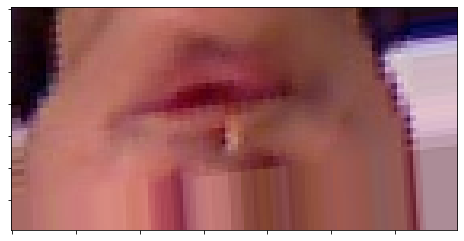

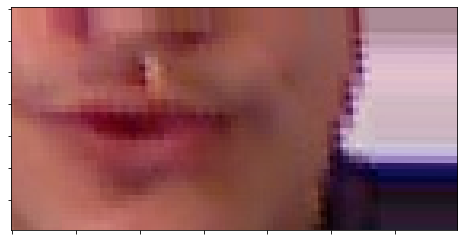

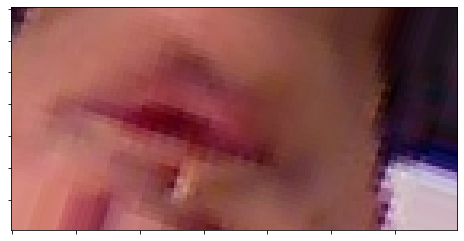

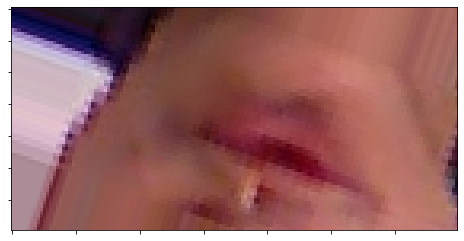

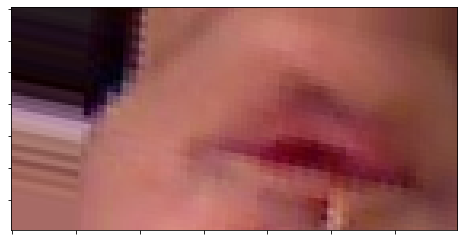

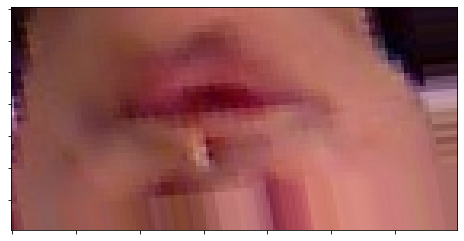

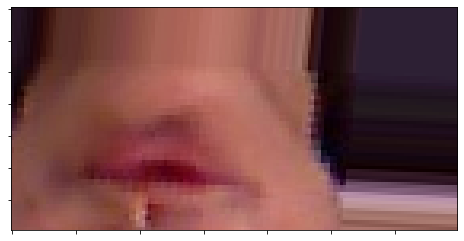

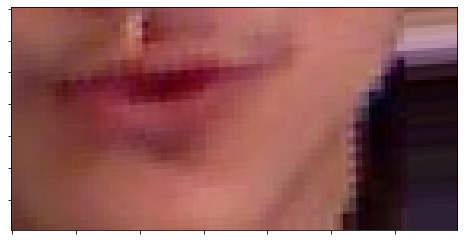

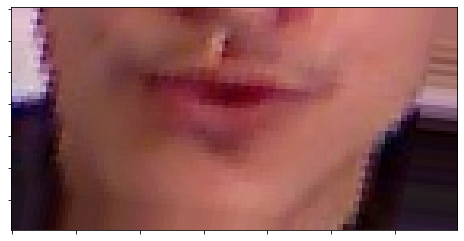

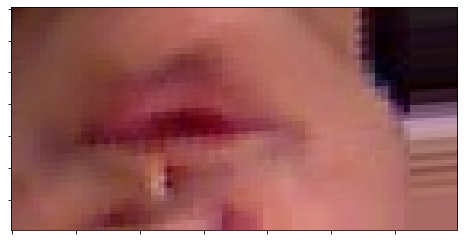

In [235]:
for x in batchX[0]:
    show_img(x, figsize=(8, 8))
    print(x.shape)

(70, 140, 3)
(70, 140, 3)
(70, 140, 3)
(70, 140, 3)
(70, 140, 3)
(70, 140, 3)
(70, 140, 3)
(70, 140, 3)
(70, 140, 3)
(70, 140, 3)


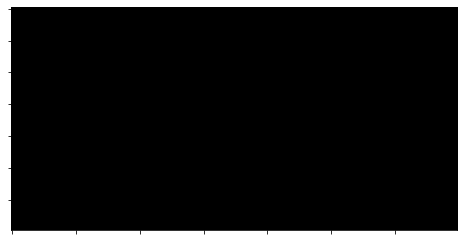

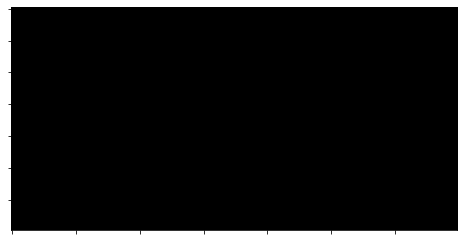

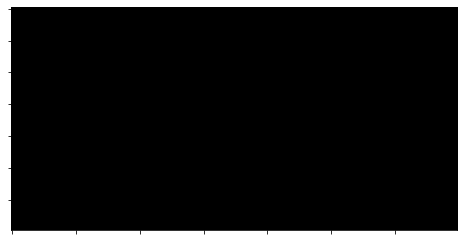

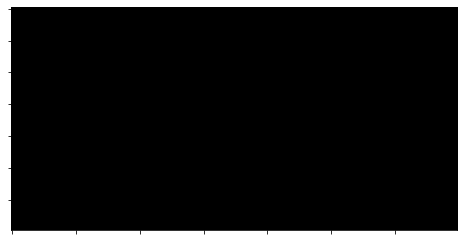

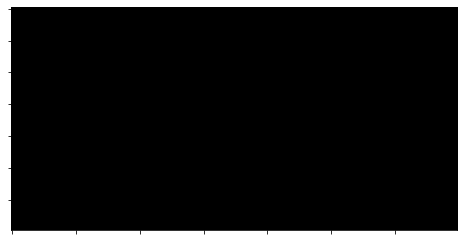

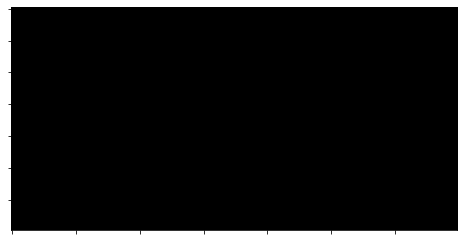

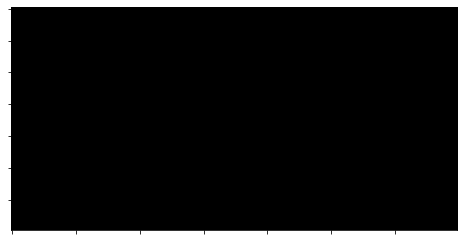

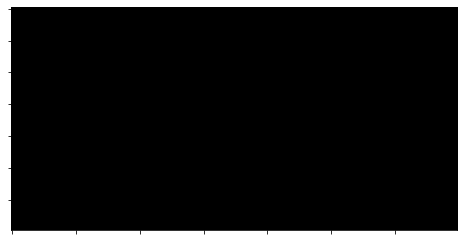

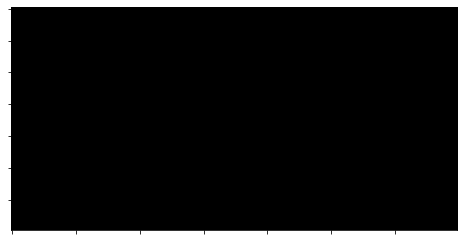

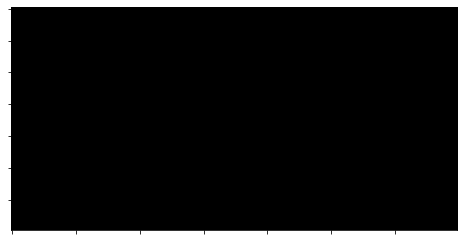

In [237]:
for x in batchX[1]:
    show_img(x, figsize=(8, 8))
    print(x.shape)

In [198]:
print(math.ceil(6920/(1*10)))
print(math.ceil((1510/(1*10))))

692
151


## MobileNetV2 + LSTM

In [ ]:
# video = keras.layers.Input(shape=(13, 70, 140, 3))

# cnn_base = keras.applications.MobileNetV2(input_shape=(70, 140, 3), include_top=False)
# cnn_out = keras.layers.GlobalAveragePooling2D()(cnn_base.output)

# cnn = Model(input=cnn_base.input, output=cnn_out)
# encoded_frames = keras.layers.TimeDistributed(cnn)(video)

# encoded_sequence = keras.layers.LSTM(26)(encoded_frames)
# outputs = keras.layers.Bidirectional(Dense(10, activation="softmax"))(encoded_sequence)

# mn_lstm = Model([video], outputs)

In [ ]:
# adam2 = keras.optimizers.Adam(lr=0.0001)
# save_weights = keras.callbacks.ModelCheckpoint('mn_lstm.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
# mn_lstm.compile(loss='categorical_crossentropy',optimizer=adam2,metrics=['accuracy'])
# mn_lstm.summary()

In [ ]:
# history = mn_lstm.fit_generator(train_data, epochs=50, steps_per_epoch=4172, 
#                               validation_data=val_data, validation_steps=127, shuffle=True)

## LipNet

In [199]:
model_small = keras.models.Sequential()

model_small.add(ZeroPadding3D(padding=(1, 2, 2), input_shape=(10, 70, 140, 3)))
model_small.add(Conv3D(32, (3, 5, 5), strides=(1, 2, 2), activation='relu'))
model_small.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
model_small.add(Dropout(.2))

model_small.add(ZeroPadding3D(padding=(1, 2, 2)))
model_small.add(Conv3D(64, (3, 5, 5), strides=(1, 1, 1), activation='relu'))
model_small.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
model_small.add(Dropout(.2))

model_small.add(ZeroPadding3D(padding=(1, 1, 1)))
model_small.add(Conv3D(96, (3, 3, 3), strides=(1, 2, 2), activation='relu'))
model_small.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
model_small.add(Dropout(.2))

model_small.add(TimeDistributed(Flatten()))

model_small.add(GRU(40))

model_small.add(Dense(10, activation='softmax'))

In [200]:
model_small.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding3d_13 (ZeroPaddi (None, 12, 74, 144, 3)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 10, 35, 70, 32)    7232      
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 10, 17, 35, 32)    0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 10, 17, 35, 32)    0         
_________________________________________________________________
zero_padding3d_14 (ZeroPaddi (None, 12, 21, 39, 32)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 10, 17, 35, 64)    153664    
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 10, 8, 17, 64)   

In [201]:
# adam2 = keras.optimizers.Adam(lr=0.001)
# save_weights = keras.callbacks.ModelCheckpoint('model_small.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
# model_small.compile(loss='categorical_crossentropy',optimizer=adam2,metrics=['accuracy'])
# model_small.summary()

In [202]:
# history = model_small.fit_generator(train_data, epochs=50, steps_per_epoch=173, 
#                               validation_data=val_data, validation_steps=151, shuffle=False)

In [203]:
model_small = keras.models.Sequential()

model_small.add(ZeroPadding2D(padding=(2, 2), input_shape=(70, 140, 3)))
model_small.add(Conv2D(32, (5, 5), strides=(2, 2), activation='relu', kernel_regularizer=l2(0.01)))
model_small.add(BatchNormalization())
model_small.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_small.add(Dropout(.2))

model_small.add(ZeroPadding2D(padding=(2, 2)))
model_small.add(Conv2D(64, (5, 5), strides=(1, 1), activation='relu', kernel_regularizer=l2(0.01)))
model_small.add(BatchNormalization())
model_small.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_small.add(Dropout(.2))

model_small.add(ZeroPadding2D(padding=(1, 1)))
model_small.add(Conv2D(96, (3, 3), strides=(2, 2), activation='relu', kernel_regularizer=l2(0.01)))
model_small.add(BatchNormalization())
model_small.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_small.add(Flatten())

In [ ]:
# video = keras.layers.Input(shape=(13, 70, 140, 3))

# cnn_base = keras.applications.MobileNetV2(input_shape=(70, 140, 3), include_top=False)
# cnn_out = keras.layers.GlobalAveragePooling2D()(cnn_base.output)

# cnn = Model(input=cnn_base.input, output=cnn_out)
# encoded_frames = keras.layers.TimeDistributed(cnn)(video)

# encoded_sequence = keras.layers.LSTM(26)(encoded_frames)
# outputs = keras.layers.Bidirectional(Dense(10, activation="softmax"))(encoded_sequence)

# mn_lstm = Model([video], outputs)

In [218]:
cnn_base = keras.applications.VGG16(input_shape=(70, 140, 3), include_top=False, pooling='max')
cnn_base.output

58892288/58889256 [==============================] - 13s 0us/step


<tf.Tensor 'global_max_pooling2d_16/Max:0' shape=(None, 512) dtype=float32>

In [219]:
image_input = Input(shape=(70, 140, 3))

cnn_base = keras.applications.VGG16(input_shape=(70, 140, 3), include_top=False, pooling='max')
cnn = Model(input=cnn_base.input, output=cnn_base.output)

#cnn = Model(input=model_small.input, output=model_small.output)
encoded_frames = cnn(image_input)
encoded_frames_rnn = Reshape((-1, 512))(encoded_frames)
encoded_sequence = LSTM(512)(encoded_frames_rnn)

output = Dense(10, activation='softmax')(encoded_sequence)

seq = Model(inputs=image_input, outputs=output)

/home/dmitrii/pythonenvs/lr1_3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`
  after removing the cwd from sys.path.


In [220]:
adam2 = keras.optimizers.Adam(lr=0.001)
save_weights = keras.callbacks.ModelCheckpoint('model_small.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
seq.compile(loss='categorical_crossentropy',optimizer=adam2,metrics=['accuracy'])
seq.summary()

Model: "model_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, 70, 140, 3)        0         
_________________________________________________________________
model_75 (Model)             (None, 512)               14714688  
_________________________________________________________________
reshape_24 (Reshape)         (None, 1, 512)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dense_55 (Dense)             (None, 10)                5130      
Total params: 16,819,018
Trainable params: 16,819,018
Non-trainable params: 0
_________________________________________________________________


In [221]:
history = seq.fit_generator(train_data, epochs=50,
                              validation_data=val_data, shuffle=False)

Epoch 1/50
692/692 [==============================] - 224s 323ms/step - loss: 1.9630 - accuracy: 0.7688 - val_loss: 5.2452e-06 - val_accuracy: 0.0861
Epoch 2/50
 19/692 [..............................] - ETA: 3:24 - loss: 7.5118 - accuracy: 0.1579

KeyboardInterrupt: 

## dsadsa

In [ ]:
# tf.compat.v1.reset_default_graph()

In [ ]:
# tf.compat.v1.keras.backend.clear_session()